# CNN utilisant Tensorflow
####  Python · Données de classification des déchets

In [1]:
import tensorflow as tf
from tensorflow import keras
import os
import shutil
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.metrics import confusion_matrix
import random
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,BatchNormalization,Flatten,AvgPool2D
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
#!pip install keras-tuner -q

In [30]:
import keras_tuner as kt


In [82]:
path='C:/Users/user/Desktop/datasetOR'
target=os.listdir(os.path.join(path,'TRAIN'))
print(target)

['O', 'R']


In [83]:
new_dir='C:/Users/user/Desktop/datasetOR/data'
train_path=new_dir+'/train'
valid_path=new_dir+'/valid'
test_path=new_dir+'/test'

In [84]:
def create_dir():
    if not os.path.isdir(new_dir):
        os.makedirs(new_dir)
        os.makedirs(train_path)
        os.makedirs(valid_path)
        os.makedirs(test_path)
        for label in target:
            os.makedirs(os.path.join(train_path,label))
            os.makedirs(os.path.join(valid_path,label))
            os.makedirs(os.path.join(test_path,label))

In [85]:
create_dir()

In [86]:
def check_path():
    print(f'{new_dir}: {os.path.isdir(new_dir)}')
    print(f'{train_path}:{os.path.isdir(train_path)}')
    print(f'{valid_path}:{os.path.isdir(valid_path)}')
    print(f'{test_path}:{os.path.isdir(test_path)}')
    for label in target:
        print(f'{os.path.join(train_path,label)}:{os.path.isdir(os.path.join(train_path,label))}')
        print(f'{os.path.join(valid_path,label)}:{os.path.isdir(os.path.join(valid_path,label))}')
        print(f'{os.path.join(test_path,label)}:{os.path.isdir(os.path.join(test_path,label))}')


In [87]:
check_path()

C:/Users/user/Desktop/datasetOR/data: True
C:/Users/user/Desktop/datasetOR/data/train:True
C:/Users/user/Desktop/datasetOR/data/valid:True
C:/Users/user/Desktop/datasetOR/data/test:True
C:/Users/user/Desktop/datasetOR/data/train\O:True
C:/Users/user/Desktop/datasetOR/data/valid\O:True
C:/Users/user/Desktop/datasetOR/data/test\O:True
C:/Users/user/Desktop/datasetOR/data/train\R:True
C:/Users/user/Desktop/datasetOR/data/valid\R:True
C:/Users/user/Desktop/datasetOR/data/test\R:True


In [88]:
def find_image_size():
    image_path=os.path.join(path,'TRAIN/O')
    for image in os.listdir(image_path):
        img_path=os.path.join(image_path,image)
        img=cv2.imread(img_path)
        print(img.shape)
        break

In [89]:
find_image_size()

(664, 500, 3)


In [90]:
img_size=(96,96) 
batch_size=20
epochs=5
train_valid_path=path+'/TRAIN' 
testing_path=path+'/TEST'
steps_per_epoch=250

In [91]:
def load_train_images(img_per_category=15):
    for folder in os.listdir(train_valid_path):
        folder_path=os.path.join(train_valid_path,folder)
        print(f'Loading training images for {folder}')
        train_image_set=random.sample(os.listdir(folder_path),img_per_category)
        dest=os.path.join(train_path,folder)
        for c in tqdm(train_image_set):
            img_path=os.path.join(folder_path,c)
            shutil.copy(img_path,dest)
def load_valid_images(img_per_category=7):
    for folder in os.listdir(train_valid_path):
        folder_path=os.path.join(train_valid_path,folder)
        print(f'Loading validation images for {folder}')
        dest=os.path.join(valid_path,folder)
        valid_image_set=random.sample(os.listdir(folder_path),img_per_category)
        for c in tqdm(valid_image_set):
            img_path=os.path.join(folder_path,c)
            shutil.copy(img_path,dest)
def load_test_images(img_per_category=10):
    for folder in os.listdir(testing_path):
        print(f'Loading the testing images for {folder}')
        folder_path=os.path.join(testing_path,folder)
        dest=os.path.join(test_path,folder)
        test_image_set=random.sample(os.listdir(folder_path),img_per_category)
        for c in tqdm(test_image_set):
            img_path=os.path.join(folder_path,c)
            shutil.copy(img_path,dest)

In [92]:
load_train_images(17)

 82%|████████▏ | 14/17 [00:00<00:00, 131.76it/s]

Loading training images for O
Loading training images for R


100%|██████████| 17/17 [00:00<00:00, 127.91it/s]


In [93]:
load_valid_images(3)


100%|██████████| 3/3 [00:00<00:00, 500.47it/s]

Loading validation images for O
Loading validation images for R


In [94]:
load_test_images(5)

  0%|          | 0/5 [00:00<?, ?it/s]

Loading the testing images for O
Loading the testing images for R


100%|██████████| 5/5 [00:00<00:00, 30.03it/s]


In [95]:
datagen=ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input,rescale=1./255)
train_batch=ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input,rescale=1./255,horizontal_flip=True).flow_from_directory(directory=train_path,target_size=img_size,classes=target,batch_size=batch_size)
valid_batch=datagen.flow_from_directory(directory=valid_path,target_size=img_size,classes=target,batch_size=batch_size)
test_batch=datagen.flow_from_directory(directory=test_path,target_size=img_size,classes=target,batch_size=batch_size,shuffle=False)

Found 41 images belonging to 2 classes.
Found 21 images belonging to 2 classes.
Found 31 images belonging to 2 classes.


In [96]:
images,labels=train_batch.next()
print(np.max(images))

0.59239614


In [97]:
def myModel(img):
    layer=int(np.log2(img))
    model=[]
    model+=[
        Conv2D(filters=32,kernel_size=(3,3),strides=1,padding='same',input_shape=(img,img,3),activation='relu'),
        BatchNormalization(),
        Conv2D(filters=32,kernel_size=(3,3),strides=1,padding='same',activation='relu'),
        BatchNormalization(),
        AvgPool2D(pool_size=(2,2),strides=2),
    ]
    layer-=1
    filters=64
    for i in range(layer):
        model+=[
            Conv2D(filters=filters,kernel_size=(3,3),strides=1,padding='same',activation='relu'),
            BatchNormalization(),
            Conv2D(filters=filters,kernel_size=(3,3),strides=1,padding='same',activation='relu'),
            BatchNormalization(),
            AvgPool2D(pool_size=(2,2),strides=2),
        ]
        filters*=2
    model+=[
        Flatten(),
        Dense(units=4096,activation='relu'),
        Dense(units=4096,activation='relu'),
        Dense(units=len(target),activation='softmax')
    ]
    return Sequential(model)

In [98]:
def build_model(hp):
    model=myModel(96)
    hp_lr=hp.Choice('learning_rate',values=list(np.linspace(start=0.0001,stop=0.0006,num=12)))
    model.compile(optimizer=Adam(lr=hp_lr),loss='categorical_crossentropy',metrics=['accuracy'])
    return model

In [99]:
tuner=kt.Hyperband(build_model,objective='val_accuracy',max_epochs=epochs)


INFO:tensorflow:Reloading Oracle from existing project .\untitled_project\oracle.json
INFO:tensorflow:Reloading Tuner from .\untitled_project\tuner0.json


In [100]:
stop_early=EarlyStopping(monitor='val_loss',patience=5)


In [101]:
tuner.search(train_batch,epochs=5,validation_data=valid_batch,callbacks=[stop_early])


INFO:tensorflow:Oracle triggered exit


In [102]:
best_hp=best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hp.get('learning_rate'))

0.0003727272727272727


In [103]:
model=tuner.hypermodel.build(best_hp)


In [104]:
history=model.fit(x=train_batch,validation_data=valid_batch,epochs=epochs,steps_per_epoch=steps_per_epoch,verbose=2,batch_size=batch_size)

Epoch 1/5
250/250 - 11s - loss: 0.6787 - accuracy: 0.4634 - val_loss: 0.7022 - val_accuracy: 0.4762


In [105]:
pre=model.predict(x=test_batch,verbose=0)
np.round(pre)
cm=confusion_matrix(y_true=test_batch.classes,y_pred=np.argmax(pre,axis=-1))
print(f'Accuracy: {(cm.trace()/cm.sum())*100}')

Accuracy: 48.38709677419355


In [106]:
val_accuracy=history.history['val_accuracy']
train_accuracy=history.history['accuracy']

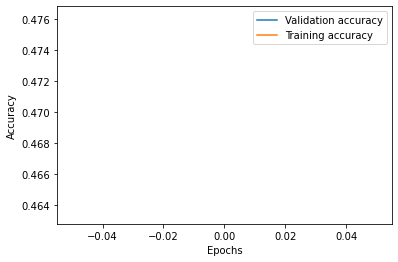

In [107]:
plt.plot(val_accuracy)
plt.plot(train_accuracy)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Validation accuracy','Training accuracy'])